# AlCu2Mn XRD

In [1]:
import numpy as np
import math
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import csv

In [2]:
wavelength = 0.1542 #nm
lattice_constant = 0.5949 #nm
# FCC lattice

In [3]:
planes_df = pd.read_csv('All_Planes_hkl.csv')
miller_indices = planes_df.values
# Store this in a dataframe:
miller_list = [list(row) for row in miller_indices[0:25]]
df = pd.DataFrame({'Miller': miller_list})

In [4]:
df['hkl_squared'] = df['Miller'].apply(lambda x: x[0]**2 + x[1]**2 + x[2]**2)
df['sin theta (rad)'] = df['hkl_squared'].apply(lambda x: math.sqrt((wavelength**2/(4*lattice_constant**2))*x))
df['theta (rad)'] = df['sin theta (rad)'].apply(lambda x:(math.asin(x)))
df['theta (deg)'] = df['theta (rad)'].apply(lambda x: np.rad2deg(x))
df['2 theta (deg)'] = df['theta (deg)'].apply(lambda x: 2 * x)

In [5]:
df

,Miller,hkl_squared,sin theta (rad),theta (rad),theta (deg),2 theta (deg)
0,"[1, 0, 0]",1,0.129602,0.129967,7.446572,14.893143
1,"[1, 1, 0]",2,0.183284,0.184326,10.561123,21.122246
2,"[1, 1, 1]",3,0.224477,0.226406,12.972101,25.944202
3,"[2, 0, 0]",4,0.259203,0.262197,15.022790,30.045579
4,"[2, 1, 0]",5,0.289798,0.294016,16.845864,33.691728
5,"[2, 1, 1]",6,0.317458,0.323047,18.509254,37.018509
6,"[2, 2, 0]",8,0.366569,0.375318,21.504156,43.008313
7,"[2, 2, 1]",9,0.388805,0.399334,22.880154,45.760307
8,"[3, 0, 0]",9,0.388805,0.399334,22.880154,45.760307
9,"[3, 1, 0]",10,0.409836,0.422275,24.194551,48.389102


In [6]:
def store_atom_positions(csv_name):
    file_path = f"/Users/hendrikvossler/Desktop/GitHub/XRD/{csv_name}"
    
    atom_positions = {}

    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # skip the header
        for row in reader:
            atom_type = row[0]
            coords = list(map(float, row[1:]))
            if atom_type not in atom_positions:
                atom_positions[atom_type] = []
            atom_positions[atom_type].append(coords)

    # Convert lists to numpy arrays
    for atom_type, positions in atom_positions.items():
        atom_positions[atom_type] = np.array(positions)

    return atom_positions

In [7]:
atom_positions = store_atom_positions('MnAlCu2_atom_positions.csv')

In [8]:
# Define atom positons in cubic cell:
# Al_positions = np.array([[0.0, 0.0, 0.0], [0.5, 0.5, 0.0], [0.5, 0.0, 0.5], [0.0, 0.5, 0.5]])
# Cu_positions = np.array([[0.25, 0.25, 0.25], [0.75, 0.25, 0.25], [0.25, 0.25, 0.75], [0.75, 0.25, 0.75], [0.25, 0.75, 0.75], [0.75, 0.75, 0.75], [0.25, 0.75, 0.25], [0.75, 0.75, 0.25]])
# Mn_positions = np.array([[0.5, 0.5, 0.5], [1.0, 0.5, 1.0], [0.5, 1, 1], [1.0, 1.0, 0.5]]) # are these correct? 
# ##Mn_positions = np.array([[0.5, 0.5, 0.5], [0, 0, 0.5], [0.5, 0, 1], [0, 0.5, 1]])

In [9]:
# This calculates the term that will be multiplied by the atomic scattering factor
# for each atom type and for each miller incices
def compute_structure_factor_term_i(atom_positions, miller_indices_array):
    results = {}
    
    for miller_indices in miller_indices_array:
        h, k, l = miller_indices
        total = 0
        
        for position in atom_positions:
            #position_adjusted = 2*position # distribute the 2 in the exponential factor to each atom position
            x, y, z = position
            value = x * h + y * k + z * l
            term = np.round(np.exp(2j*np.pi*value), 2)
            total += term
        
        # Store the result with Miller indices as the key
        results[tuple(miller_indices)] = total
    
    return results

In [10]:
Al_structure_factor_term = compute_structure_factor_term_i(atom_positions["Al"], miller_indices)
Cu_structure_factor_term = compute_structure_factor_term_i(atom_positions["Cu"], miller_indices)
Mn_structure_factor_term = compute_structure_factor_term_i(atom_positions["Mn"], miller_indices)
print("Al", Al_structure_factor_term)
print("Cu", Cu_structure_factor_term)
print("Mn",Mn_structure_factor_term)

Al {(1, 0, 0): 0j, (1, 1, 0): 0j, (1, 1, 1): (4+0j), (2, 0, 0): (4+0j), (2, 1, 0): 0j, (2, 1, 1): 0j, (2, 2, 0): (4+0j), (2, 2, 1): 0j, (3, 0, 0): 0j, (3, 1, 0): 0j, (3, 1, 1): (4+0j), (2, 2, 2): (4+0j), (3, 2, 0): 0j, (3, 2, 1): 0j, (4, 0, 0): (4+0j), (3, 2, 2): 0j, (4, 1, 0): 0j, (3, 3, 0): 0j, (4, 1, 1): 0j, (3, 3, 1): (4+0j), (4, 2, 0): (4+0j), (4, 2, 1): 0j, (3, 3, 2): 0j, (4, 2, 2): (4+0j), (5, 0, 0): 0j, (4, 3, 1): 0j, (5, 1, 0): 0j, (3, 3, 3): (4+0j), (5, 1, 1): (4+0j), (4, 3, 2): 0j, (5, 2, 0): 0j, (5, 2, 1): 0j, (4, 4, 0): (4+0j), (4, 4, 1): 0j, (5, 2, 2): 0j, (4, 3, 3): 0j, (5, 3, 0): 0j, (5, 3, 1): (4+0j), (4, 4, 2): (4+0j), (6, 0, 0): (4+0j), (6, 1, 0): 0j, (5, 2, 3): 0j, (6, 2, 0): (4+0j), (4, 4, 3): 0j, (5, 4, 0): 0j, (5, 4, 1): 0j, (5, 2, 4): 0j, (4, 4, 4): (4+0j)}
Cu {(1, 0, 0): 0j, (1, 1, 0): 0j, (1, 1, 1): 0j, (2, 0, 0): (-8+0j), (2, 1, 0): 0j, (2, 1, 1): 0j, (2, 2, 0): (8+0j), (2, 2, 1): 0j, (3, 0, 0): 0j, (3, 1, 0): 0j, (3, 1, 1): 0j, (2, 2, 2): (-8+0j), (3, 2, 0):

In [11]:
# This calculates f, the atomic scattering factor, for each atom time at each theta angle 
# check the angle calculation units
def calc_atomic_scattering_factor(theta, atomic_number, a1, b1, a2, b2, a3, b3, a4=None, b4=None, wavelength = 0.1542):
    s = math.sin(theta)/(wavelength*10)
    f = atomic_number - (41.78214 * s**2) * (a1*np.e**(-b1*s**2) + a2*np.e**(-b2*s**2) + a3*np.e**(-b3*s**2) + a4*np.e**(-b4*s**2))
    return f

In [12]:
# Populate df with atomic scattering factors
df['Al_f'] = df['theta (rad)'].apply(lambda x: calc_atomic_scattering_factor(x, 13, 2.276, 72.322, 2.428, 19.773, 0.858, 3.080, 0.317, 0.408))
df['Cu_f'] = df['theta (rad)'].apply(lambda x: calc_atomic_scattering_factor(x, 29, 1.579, 62.940, 1.820, 12.453, 1.658, 2.504, 0.532, 0.333))
df['Mn_f'] = df['theta (rad)'].apply(lambda x: calc_atomic_scattering_factor(x, 25, 2.747, 67.786, 2.456, 15.674, 1.792, 3, 0.498, 0.357))

In [13]:
# Define function to calculate multiplicity facor for each plane:
def get_unique_permutations(hkl):
    # Get all permutations of the Miller indices
    perms = list(itertools.permutations(hkl))
    
    # For each permutation, consider all possible sign changes
    all_permutations = []
    for perm in perms:
        signs = itertools.product([1, -1], repeat=3)
        for sign in signs:
            all_permutations.append(tuple([i*j for i, j in zip(perm, sign)]))
    
    # Return unique permutations (planes)
    return set(all_permutations)

In [14]:
# Calculate the structure factors using the atomic scattering factors- 
# i need to go through this math to make sure it is correct- 
# it definitely doesnt match the peak intensities given on materials project
df['Structure Factor'] = (df['Al_f'] * df['Miller'].apply(lambda x: Al_structure_factor_term[tuple(x)]) +
                              (df['Cu_f'] * df['Miller'].apply(lambda x: Cu_structure_factor_term[tuple(x)])) +
                              (df['Mn_f'] * df['Miller'].apply(lambda x: Mn_structure_factor_term[tuple(x)])))
df['conj'] = df['Structure Factor'].apply(lambda x: np.conj(x))
result = (df["Structure Factor"]*df['conj'])
df['F^2'] = result.apply(lambda x: x.real)
#df['p'] = [8, 6, 12, 24, 8, 6, 24, 24, 24]
df['p'] = df['Miller'].apply(lambda x: len(get_unique_permutations(x)))
df['Lorentz_factor'] = df['theta (rad)'].apply(lambda x: (1+(math.cos(2*x)**2)) / (math.sin(x)**2 * math.cos(x)))
df['Intensity'] = df['F^2']*df['p']*df['Lorentz_factor']
df["Intensity_norm"] = (df["Intensity"]/df["Intensity"].max())*100


In [15]:
df

,Miller,hkl_squared,sin theta (rad),theta (rad),theta (deg),2 theta (deg),Al_f,Cu_f,Mn_f,Structure Factor,conj,F^2,p,Lorentz_factor,Intensity,Intensity_norm
0,"[1, 0, 0]",1,0.129602,0.129967,7.446572,14.893143,11.632681,27.571865,23.184379,0.0000000+0.0000000j,0.0000000-0.0000000j,0.000000,6,116.118383,0.000000e+00,0.000000
1,"[1, 1, 0]",2,0.183284,0.184326,10.561123,21.122246,10.761502,26.458648,21.909473,0.0000000+0.0000000j,0.0000000-0.0000000j,0.000000,12,56.629617,0.000000e+00,0.000000
2,"[1, 1, 1]",3,0.224477,0.226406,12.972101,25.944202,10.160856,25.533969,20.935051,-43.096781+0.000000j,-43.096781-0.000000j,1857.332559,8,36.832158,5.472765e+05,4.656090
3,"[2, 0, 0]",4,0.259203,0.262197,15.022790,30.045579,9.713868,24.727892,20.134569,-78.429389+0.000000j,-78.429389-0.000000j,6151.169084,6,26.958064,9.949417e+05,8.464712
4,"[2, 1, 0]",5,0.289798,0.294016,16.845864,33.691728,9.359897,24.002012,19.442136,0.0000000+0.0000000j,0.0000000-0.0000000j,0.000000,24,21.053769,0.000000e+00,0.000000
5,"[2, 1, 1]",6,0.317458,0.323047,18.509254,37.018509,9.066936,23.335224,18.823567,0.0000000+0.0000000j,0.0000000-0.0000000j,0.000000,24,17.134770,0.000000e+00,0.000000
6,"[2, 2, 0]",8,0.366569,0.375318,21.504156,43.008313,8.600670,22.136560,17.743943,282.470933+0.000000j,282.470933-0.000000j,79789.827740,12,12.275994,1.175399e+07,100.000000
7,"[2, 2, 1]",9,0.388805,0.399334,22.880154,45.760307,8.409980,21.593279,17.266678,0.0000000+0.0000000j,0.0000000-0.0000000j,0.000000,24,10.674774,0.000000e+00,0.000000
8,"[3, 0, 0]",9,0.388805,0.399334,22.880154,45.760307,8.409980,21.593279,17.266678,0.0000000+0.0000000j,0.0000000-0.0000000j,0.000000,6,10.674774,0.000000e+00,0.000000
9,"[3, 1, 0]",10,0.409836,0.422275,24.194551,48.389102,8.240240,21.082631,16.824633,0.0000000+0.0000000j,0.0000000-0.0000000j,0.000000,24,9.405213,0.000000e+00,0.000000


100 should not be showing up - FCC 100 should be forbidden reflection. my copper is causing it to have reflection. 210 as well  - fixed this.   
when figuring out if a reflection is forbidden. do you ignore the basis??? just look at the fcc lattice? - result independtent of basis.   
what to do when two places have same 2 theta angle? - add them up.   
wCan i get more planes somewhere? - make them up.   

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

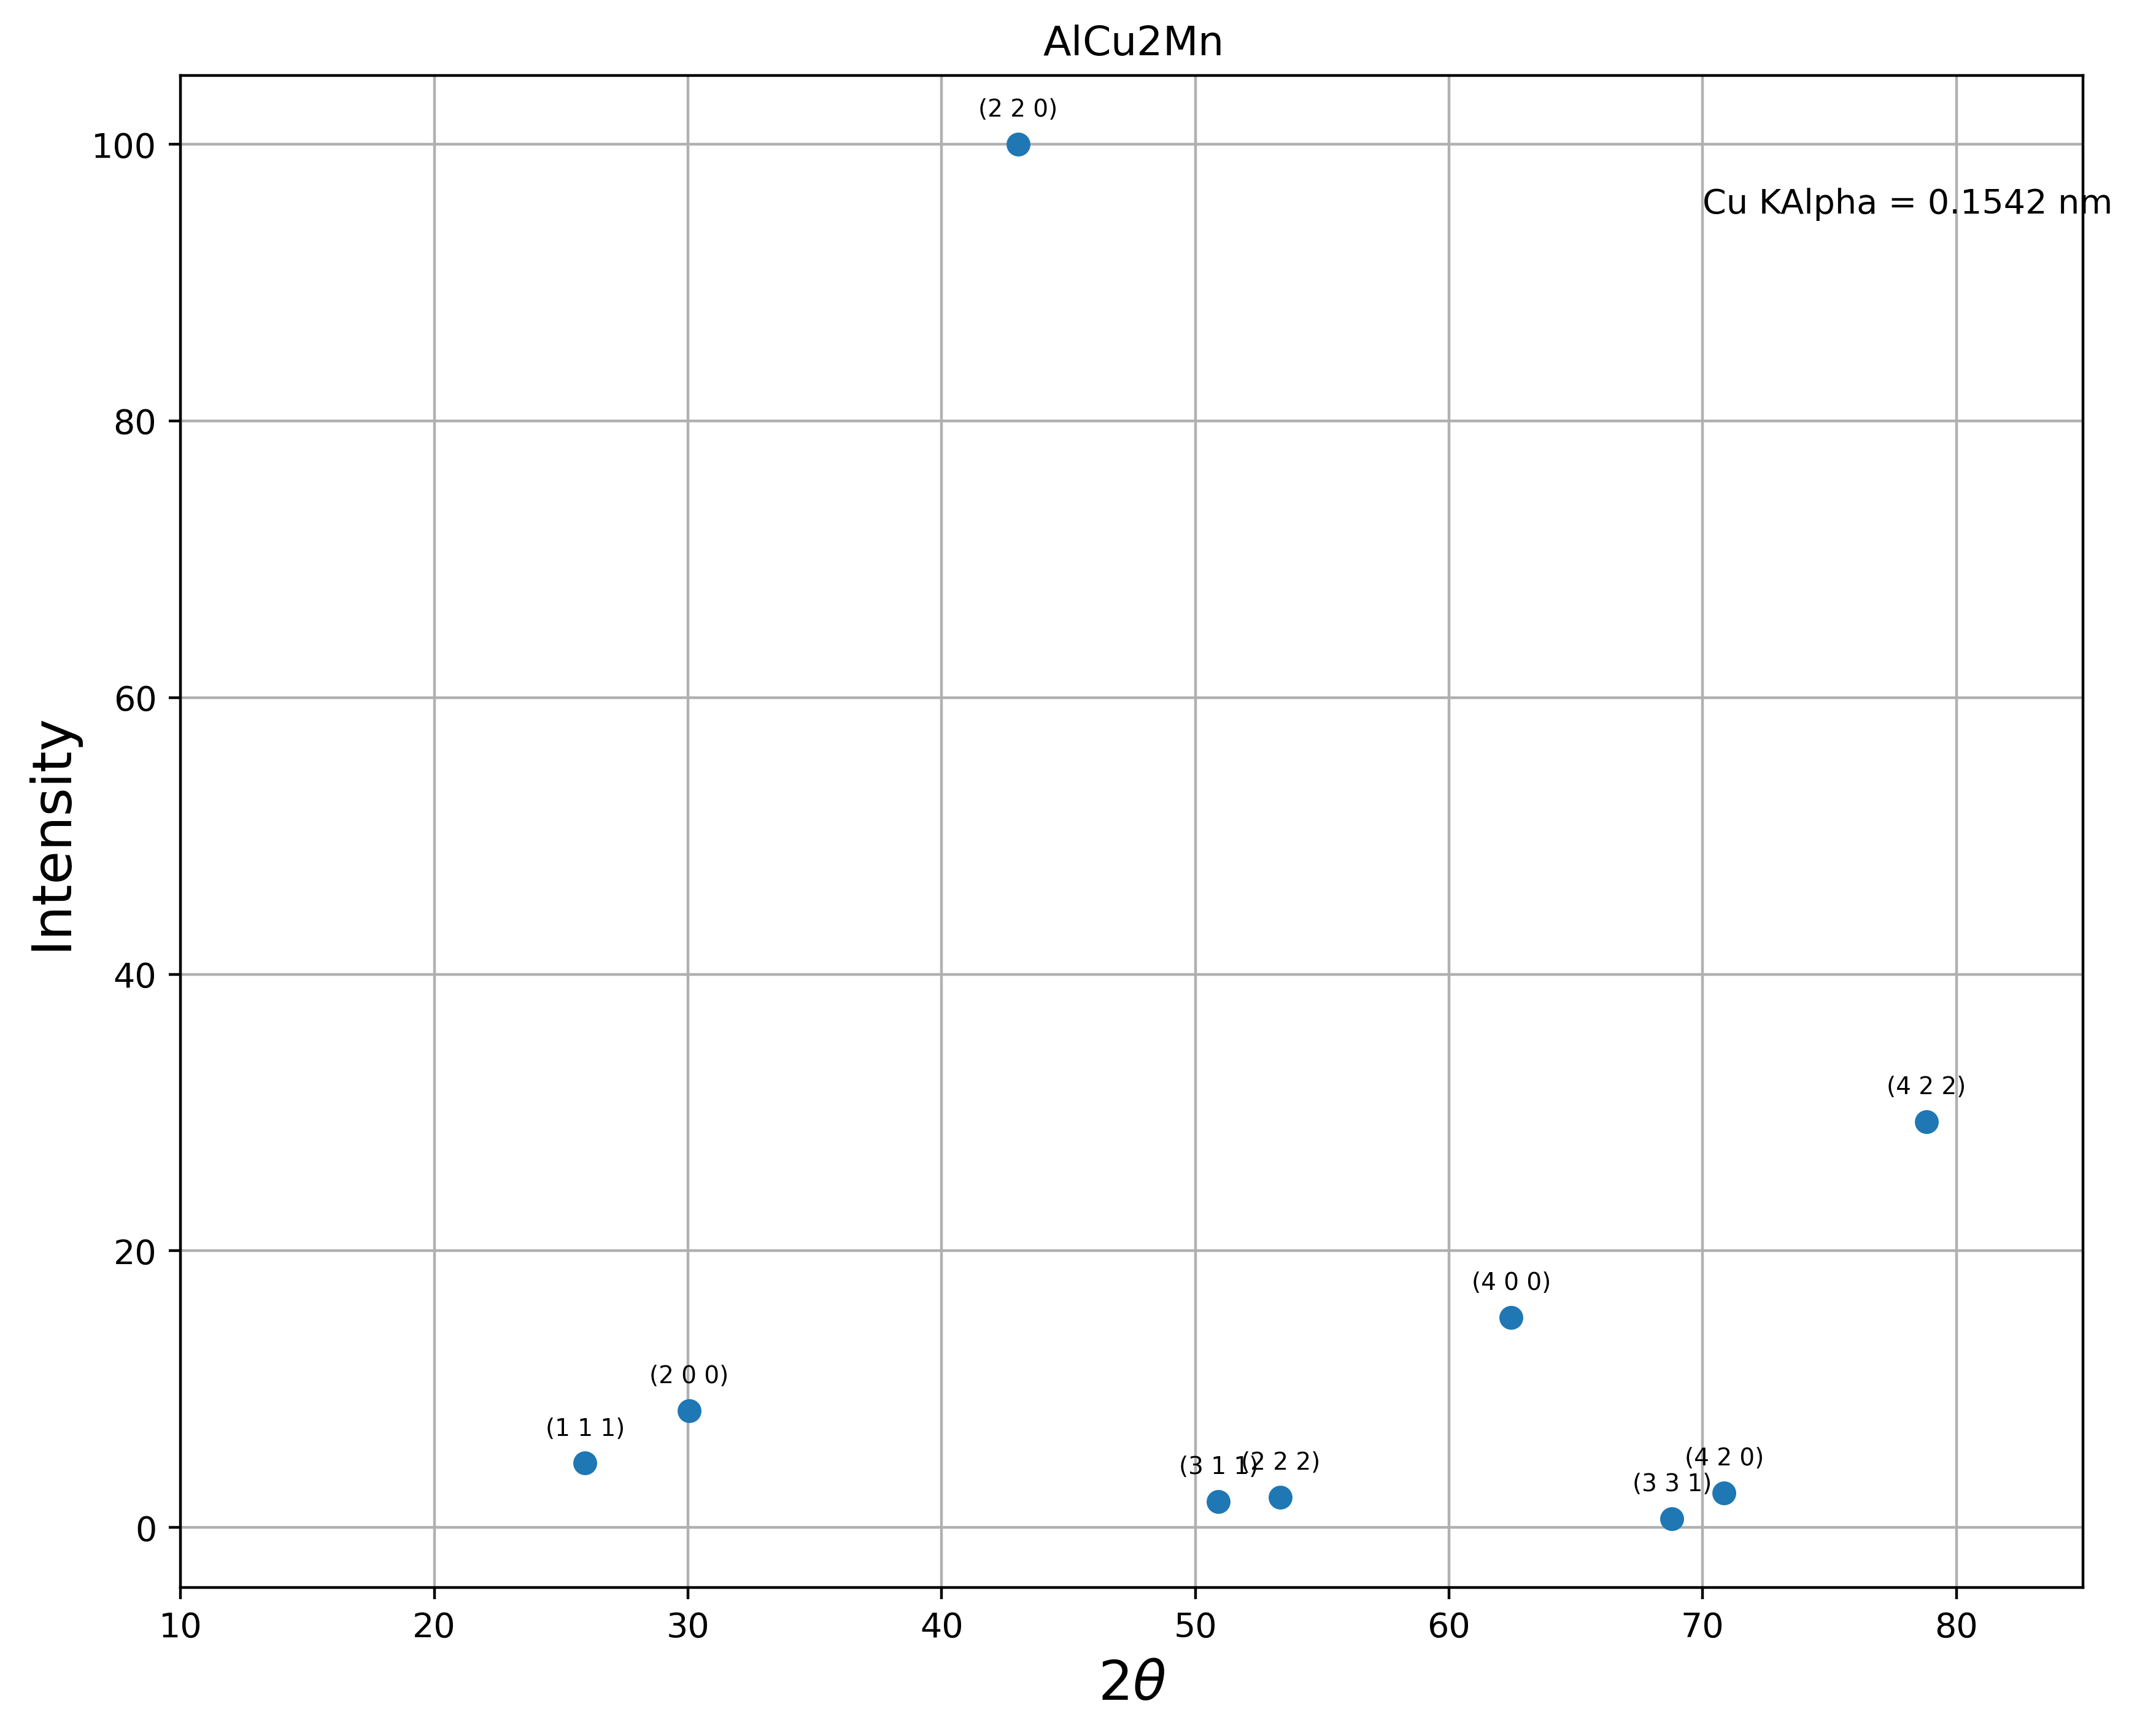

In [16]:

fig = plt.figure(figsize=(10, 8), dpi = 400)
filtered_df = df[df['Intensity_norm'] != 0]
x = filtered_df['2 theta (deg)']
y = filtered_df['Intensity_norm']
plt.plot(x, y, 'o')

# Add text labels above each data point
for index, row in filtered_df.iterrows():
    label = str(row['Miller']).replace('[', '(').replace(']', ')').replace(',', '')
    x = row['2 theta (deg)']
    y = row['Intensity_norm']
    plt.text(x, y + 0.02 * max(filtered_df['Intensity_norm']), label, ha='center', fontsize = 7)

# Figure formatting
plt.text(70, 95, "Cu KAlpha = 0.1542 nm")
plt.xlim(10, 85)
plt.xlabel("2"r'$\theta$', fontsize = 16)
plt.ylabel('Intensity', fontsize = 16)
plt.title(r'$\mathrm{AlCu2Mn}$')
plt.grid()
plt.tight_layout

if indicies are mixed (even and odd), face centered plane is forbidden. 
Basically, if i oncorperate complex numbers into my algorithim, I will be able to keep the rest of my code, because this will take care of forbidden planes better.  